# Start Pooling

In [22]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import dirichlet
import scipy.optimize as sco

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib

from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.algorithms.soo.nonconvex.ga import GA
from pooling_functions_ciullo import calc_pool_conc, PoolOptimizationProblem
from pymoo.optimize import minimize
from pymoo.operators.repair.rounding import RoundingRepair

In [56]:
from math import comb

# Parameters
n = 1  # Number of pools 
k = 25  # Number of countries

def pop_num(n, k):
    combinations = comb(n + k - 1, k)
    return combinations

print(pop_num(n, k))

1


## Define Countries and Variables for Cat Bond Development

In [75]:
#choose country
countries = [480, 212, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 882, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585]
countries_150 = [332, 388, 214, 44, 548, 192, 84, 90] 
fiji = [242]
countries_30 = [480, 212, 670, 28, 52, 662, 659, 308, 882, 780, 570, 776, 174, 184, 584, 585]

#set risk free rate, either single value or array
rf_rates = 0.00
#set risk muliplier reported by artems
artemis_multiplier = 4.11
#set sharpe ratio to beat
target_sharpe = 0.5
#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd
#define bond setting
lower_share = 0.045
prot_rp = 250

#set alpha for risk diversification optimization
RT = 500
alpha = 1-1/RT 

#set max nominal for pool
max_nominal = 100000000000

## Designe Single Country Bonds
### Define Cat Bond function

### Design Cat Bond for Country 1

In [5]:
#define empty dictionaries
bond_metrics_sng_dic = {}
returns_sng_dic = {}
premium_dic_sng_dic = {}
nominal_sng_dic = {}
pay_dam_df_sng_dic = {}
es_metrics_sng_dic = {}
int_grid_sng_dic = {}
imp_per_event_flt_sng_dic = {}
imp_admin_evt_flt_sng_dic = {}
ann_losses_dic = {}

In [ ]:
for cty in countries:
    if cty in bond_metrics_sng_dic:
        print(f"Bond for {cty} already calculated, skipping.")
        continue
    print(f'Create bond for {cty}')
    if cty in countries_150:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                                prot_rp=prot_rp, 
                                                                                                                                                                to_prot_share=lower_share,
                                                                                                                                                                buffer_distance_km=105,
                                                                                                                                                                res_exp=150,
                                                                                                                                                                grid_size=10000,
                                                                                                                                                                grid_specs=[3,3],
                                                                                                                                                                buffer_grid_size=5,
                                                                                                                                                                incl_plots=False,
                                                                                                                                                                plot_save=True)
    if cty in countries_30:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                                prot_rp=prot_rp, 
                                                                                                                                                                to_prot_share=lower_share,
                                                                                                                                                                buffer_distance_km=105,
                                                                                                                                                                res_exp=30,
                                                                                                                                                                grid_size=10000,
                                                                                                                                                                grid_specs=[1,1],
                                                                                                                                                                buffer_grid_size=1,
                                                                                                                                                                incl_plots=False,
                                                                                                                                                                plot_save=True)  
    if cty in fiji:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                                prot_rp=prot_rp, 
                                                                                                                                                                to_prot_share=lower_share,
                                                                                                                                                                buffer_distance_km=105,
                                                                                                                                                                res_exp=150,
                                                                                                                                                                grid_size=10000,
                                                                                                                                                                grid_specs=[1,1],
                                                                                                                                                                buffer_grid_size=5,
                                                                                                                                                                crs="EPSG:3832",
                                                                                                                                                                incl_plots=False,
                                                                                                                                                                plot_save=True)
    bond_metrics_sng_dic[cty] = bond_metrics
    returns_sng_dic[cty] = returns
    premium_dic_sng_dic[cty] = premium_dic
    nominal_sng_dic[cty] = nominal
    pay_dam_df_sng_dic[cty] = pay_dam_df
    es_metrics_sng_dic[cty] = es_metrics
    int_grid_sng_dic[cty] = int_grid
    imp_per_event_flt_sng_dic[cty] = imp_per_event_flt
    imp_admin_evt_flt_sng_dic[cty] = imp_admin_evt_flt
    ann_losses_dic[cty] = ann_losses

## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

### Create Multi-Country bond

In [ ]:
tranches_array = np.array([200, 600, 1200, 2400])

nominal_dic = {}
pay_dam_df_dic = {}
for cty in countries:
    nominal_dic[cty] = nominal_sng_dic[cty]
    pay_dam_df_dic[cty] = pay_dam_df_sng_dic[cty]
    
ncf_pool_tot, premiums_pool_tot, premium_dic_pool_tot, nominal_pool_tot, es_metrics_pool_tot, MES_cty_pool_tot, tranches_tot = bond_fct.mlt_cty_bond(countries=countries,pay_dam_df_dic=pay_dam_df_dic,nominals_dic=nominal_dic, tranches_array=tranches_array, opt_cap=True)

In [ ]:
sng_ann_ret = {}
sng_ann_losses = {}
nominals_sng = []
pool_tranches_ann_ret = {}
for cty in countries:
    sng_ann_ret[cty] = returns_sng_dic[cty]['Annual'][0] 
    sng_ann_losses[cty] = np.array(ann_losses_dic[cty]['losses'].apply(sum)) * nominal_sng_dic[cty]
    nominals_sng.append(nominal_sng_dic[cty])
sng_ann_losses = pd.DataFrame(sng_ann_losses)
sng_ann_ret_df = pd.DataFrame(sng_ann_ret)
bond_metrics_sng_dic_df = pd.DataFrame(bond_metrics_sng_dic)
es_metrics_df = pd.DataFrame(es_metrics_sng_dic)

for key in ncf_pool_tot:
    if key != 'Total':
        pool_tranches_ann_ret[key] = ncf_pool_tot[key] / tranches_tot.loc[tranches_tot['RP'] == key, 'nominal'].iloc[0]

pool_ann_ret = ncf_pool_tot['Total']

In [ ]:
df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
df_returns_pool = pd.DataFrame({f"{country} Returns": returns for country, returns in pool_tranches_ann_ret.items()})

r = np.mean(df_returns,axis=0)
r_pool= np.mean(df_returns_pool,axis=0)

# Create a covariance matrix
covar = df_returns.cov()
covar_pool = df_returns_pool.cov()

In [ ]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df_returns.columns)

p_ret_pool = [] # Define an empty array for portfolio returns
p_vol_pool = [] # Define an empty array for portfolio volatility
p_weights_pool = [] # Define an empty array for asset weights

num_assets_pool = len(df_returns_pool.columns)

num_portfolios = 10000  # Number of portfolios to simulate
alpha_port = 0.5

In [ ]:
for _ in range(num_portfolios):
    weights = dirichlet([alpha_port] * num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, r) 
    p_ret.append(returns)
    var = covar.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # yearly standard deviation
    p_vol.append(sd)    

    weights_pool = dirichlet([alpha_port] * num_assets_pool)
    weights_pool = weights_pool/np.sum(weights_pool)
    p_weights_pool.append(weights_pool)
    returns_pool = np.dot(weights_pool, r_pool) 
    p_ret_pool.append(returns_pool)
    var_pool = covar_pool.mul(weights_pool, axis=0).mul(weights_pool, axis=1).sum().sum()# Portfolio Variance
    sd_pool = np.sqrt(var_pool) # yearly standard deviation
    p_vol_pool.append(sd_pool)

In [ ]:
data = {'Returns':p_ret, 'Volatility':p_vol, 'Sharpe Ratio':np.array(p_ret)/np.array(p_vol)}
data_pool = {'Returns':p_ret_pool, 'Volatility':p_vol_pool, 'Sharpe Ratio':np.array(p_ret_pool)/np.array(p_vol_pool)}

for counter, symbol in enumerate(df_returns.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

for counter, symbol in enumerate(df_returns_pool.columns.tolist()):
    data_pool[symbol+' weight'] = [w[counter] for w in p_weights_pool]

In [ ]:
portfolios  = pd.DataFrame(data)
max_sharpe_idx = portfolios['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = portfolios.loc[max_sharpe_idx]
portfolios.head() # Dataframe of the 10000 portfolios created


portfolios_pool  = pd.DataFrame(data_pool)
max_sharpe_idx_pool = portfolios_pool['Sharpe Ratio'].idxmax()
max_sharpe_portfolio_pool = portfolios_pool.loc[max_sharpe_idx_pool]

In [ ]:
# Expected returns and covariance matrices
r = np.mean(df_returns, axis=0)  # Expected returns for df_returns
r_pool = np.mean(df_returns_pool, axis=0)  # Expected returns for df_returns_pool

covar = df_returns.cov()  # Covariance matrix for df_returns
covar_pool = df_returns_pool.cov()  # Covariance matrix for df_returns_pool

# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
    return np.sum(weights * mean_returns)

# Function for optimization: minimize risk for a given return
def minimize_risk(target_return, mean_returns, cov_matrix):
    # Number of assets in the portfolio
    num_assets = len(mean_returns)
    
    # Constraints: weights sum to 1, and portfolio return equals target return
    constraints = ({
        'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
    }, {
        'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
    })
    
    # Initial guess: equal weights
    initial_guess = np.ones(num_assets) / num_assets
    
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    
    # Minimize risk (objective function)
    result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x, result.fun  # Return the optimized weights and the minimized risk

# Generate a series of target returns and corresponding risks
target_returns = np.linspace(np.min(r), np.max(r), 50)  # Range of target returns
risks = []

for target_return in target_returns:
    weights, risk = minimize_risk(target_return, r, covar)
    risks.append(risk)

## Repeat for the second data set (df_returns_pool)
risks_pool = []
target_returns_pool = np.linspace(np.min(r_pool), np.max(r_pool), 50)
for target_return in target_returns_pool:
    weights, risk = minimize_risk(target_return, r_pool, covar_pool)
    risks_pool.append(risk)


In [ ]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', cmap='cividis', marker='v', s=10, alpha=0.3, grid=True, figsize=[10,10])
plt.text(max_sharpe_portfolio['Volatility'] + 0.001,max_sharpe_portfolio['Returns'],f"Max Sharpe: {max_sharpe_portfolio['Sharpe Ratio']:.2f}",fontsize=10,ha='left',va='center',color='red')
plt.plot(risks, target_returns, label="Efficient Frontier - Sng", color='blue')
plt.scatter(x=portfolios_pool['Volatility'], y=portfolios_pool['Returns'], c=portfolios_pool['Sharpe Ratio'], cmap='cividis', marker='o', s=10, alpha=0.3)
plt.text(max_sharpe_portfolio_pool['Volatility'] + 0.001,max_sharpe_portfolio_pool['Returns'],f"Max Sharpe: {max_sharpe_portfolio_pool['Sharpe Ratio']:.2f}",fontsize=10,ha='left',va='center',color='red')
plt.scatter(x=max_sharpe_portfolio_pool['Volatility'], y=max_sharpe_portfolio_pool['Returns'], color='red', marker='x', s=10, alpha=1.0)
plt.scatter(x=max_sharpe_portfolio['Volatility'], y=max_sharpe_portfolio['Returns'], color='red', marker='x', s=10, alpha=1.0)
plt.plot(risks_pool, target_returns_pool, label="Efficient Frontier - Pool", color='red')

# Plot pool point
plt.scatter(np.std(pool_ann_ret), np.mean(pool_ann_ret), label='Pool', color='purple', s=100)
plt.text(np.std(pool_ann_ret)-0.01,np.mean(pool_ann_ret),f'Sharpe: {np.mean(pool_ann_ret)/np.std(pool_ann_ret):.2f}',fontsize=10,ha='right',va='center',color='purple')

for cty in countries:
    plt.scatter(np.std(sng_ann_ret[cty]), np.mean(sng_ann_ret[cty]), label=cty, s=100)
plt.legend()

In [ ]:
x = countries.copy()
x = [str(entry) for entry in x]
x.append('pool_1')
x.append('pool_2')
y = []
for cty in countries:
    y.append(bond_metrics_sng_dic[cty]['Total Premiums'][0]/bond_metrics_sng_dic[cty]['Summed Payments'][0])
y.append(np.sum(premiums_pool_tot['Total'])/(es_metrics_pool_tot['Payout']/nominal_pool_tot))
print(y)
plt.scatter(x,y)

In [ ]:
s = []
s_pool = []
n = []
for cty in countries:
    s.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
    s_pool.append(np.sum(premiums_pool_tot[cty])*nominal_pool_tot)
    n.append(nominal_sng_dic[cty])

print((np.sum(premiums_pool_tot['Total'])*nominal_pool_tot)/np.sum(s))
print((nominal_pool_tot)/np.sum(n))
print(np.array(s_pool)/np.array(s))
country_str = [str(entry) for entry in countries]

plt.scatter(country_str, np.array(s_pool)/np.array(s))

In [45]:
sng_ann_losses = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/test_losses.csv")
nominals_sng = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/nominals_sng.csv")
#columns_to_remove = ['192', '214']
## Save the indices of the columns to be removed
#indices_to_remove = [sng_ann_losses.columns.get_loc(col) for col in columns_to_remove]
#cty_to_remove = [192, 214]
#countries_opt = [x for x in countries if x not in cty_to_remove]
#
## Remove the columns from df1
#sng_ann_losses = sng_ann_losses.drop(columns=columns_to_remove)
#
## Remove the rows from df2 using the saved indices
#nominals_sng = nominals_sng[nominals_sng['Nominals'] <= 10000000000]
##nominals_sng = nominals_sng.drop(indices_to_remove, axis=0)

Repetitions:   0%|          | 0/1 [00:00<?, ?it/s]

0.95
61789214515.604
1.3399999999999999
61789214515.60399
0.87
61789214515.60398
1.29
61789214515.60399
0.9099999999999999
66424478072.31897
1.33
61789214515.60399
1.29
61789214515.60398
0.98
61789214515.60399
0.88
61789214515.60399
0.8899999999999999
61789214515.60399
0.89
61789214515.60399
0.91
61789214515.60399
0.8800000000000001
61789214515.60399
1.3
61789214515.604
1.29
61789214515.60399
1.31
61789214515.60398
0.9299999999999999
61789214515.60397
1.34
61789214515.60399
0.8999999999999999
61789214515.60399
1.0
61789214515.60399
1.03
61789214515.60399
0.88
61789214515.60399
0.8899999999999999
61789214515.60399
0.89
63259848878.18001
1.3
61789214515.60399
1.33
61789214515.60399
n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       26 |  6.178921E+10 |  6.202406E+10 |             - |             -
1.33
61789214515.60399
1.29
61789214515.604
1.37
61789214515.60398
0.88
61789214515.60399
1.3599999999999999
61789214515.60399
1.0
61789214515.604


Repetitions:   0%|          | 0/1 [00:06<?, ?it/s]

1.08
61789214515.60399
0.92
62115801814.38092
0.98
64663548084.935715
0.86
61789214515.60397
0.96
61789214515.60399
0.8600000000000001
61789214515.60399
1.3
61789214515.60399
0.87
61789214515.60397
0.86
61789214515.60397
1.3
61789214515.60399
1.29
61789214515.604
1.0
61789214515.604
1.28
61789214515.60398
0.95
61789214515.604
1.2999999999999998
61789214515.60399
0.9
61789214515.60399
1.31
61789214515.60398
0.94
61789214515.604
    42 |     1092 |  6.178921E+10 |  6.178921E+10 |             - |             -


TypeError: 'NoneType' object is not iterable

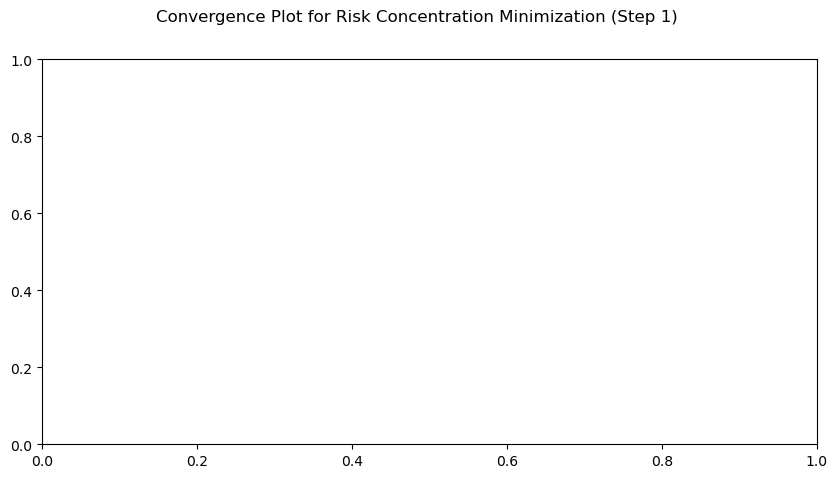

In [76]:
from tqdm import tqdm
#set number of repetitions of both minimizations (seed analysis)
n_opt_rep = 1
n = 2
opt_rep = range(0,n_opt_rep,1)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle('Convergence Plot for Risk Concentration Minimization (Step 1)')
#load names of countries in region which is optimized in
df_losses = sng_ann_losses.copy()
cntry_names = countries.copy()    
#optimize for each region to derive regional pool
#empty DataFrames to fill along the way (per region and GCM -> for each GCM seperate code file or change k)
#minimized concentration and number of countries (result of 1.Opt-Step and 2. Opt-Step)
df_conc = pd.DataFrame()
df_cntry_num = pd.DataFrame()
df_cntry_allocation = pd.DataFrame(columns = cntry_names)
#end result only with solutions with min_conc and min_cntry_num
df_result = pd.DataFrame(columns = cntry_names)
#dump with all results derived for all repetitions (--> cntry_allocation, min_conc, min_cntr, (n_gen, max_n_evals for each rep) saved)
df_result_dump = pd.DataFrame()
#Bool df where > VAR200
bools = df_losses >= np.quantile(df_losses, alpha, axis=0)
#loop through repetitions for seed analysis
for index in tqdm(opt_rep, desc=f'Repetitions'):
    #Problem definition
    problem = PoolOptimizationProblem(nominals_sng, max_nominal, df_losses, bools, alpha, n, calc_pool_conc)

    algorithm = GA(
        pop_size=pop_num(n, len(cntry_names)),
        sampling = IntegerRandomSampling(),
        crossover = HalfUniformCrossover(),
        mutation = PolynomialMutation(repair=RoundingRepair()),
        eliminate_duplicates=True,
    )

    # Solve the problem
    res_reg = minimize(problem,
                       algorithm,
                       verbose=True,
                       save_history=True)
    
    #Indices for full regional country list
    x = res_reg.X
    sorted_unique = sorted(set(x))
    rank_dict = {value: rank + 1 for rank, value in enumerate(sorted_unique)}
    x = [rank_dict[value] for value in x]

    #test if country composition was already derived in previous run, if yes not appended, in not appended as new solution
    if df_cntry_allocation.empty or not (df_cntry_allocation == x).all(axis=1).any():
        df_cntry_allocation = pd.concat([df_cntry_allocation, pd.DataFrame([x], columns=cntry_names)], ignore_index=True)
        df_conc = pd.concat([df_conc, pd.DataFrame([res_reg.F], columns=['Min_Concentration'])], ignore_index=True)
        df_cntry_num = pd.concat([df_cntry_num, pd.DataFrame([np.sum(res_reg.X)], columns=['Country_Count'])], ignore_index=True)
    else:
        None

    #new_row to dump all results with all specs derived in the two optimization steps
    new_row = pd.DataFrame(columns=[cntry_names, 
                                    'min_conc', 
                                    'min_cntry_num', 
                                    'n_gen1', 
                                    'n_eval1_max'])
    new_row = pd.DataFrame([x], columns=cntry_names)
    new_row['min_conc'] = pd.DataFrame([res_reg.F], columns = ['min_conc'])
    new_row['min_cntry_num'] = pd.DataFrame([np.sum(res_reg.X)], columns=['min_cntry_num'])
    #input for convergence plot per repetition for res_reg
    n_evals = np.array([e.evaluator.n_eval for e in res_reg.history])
    opt = np.array([e.opt[0].F for e in res_reg.history])
    ax.plot(n_evals, opt, '--')
    ax.set_ylabel('Minimum Concentration')
    ax.set_xlabel('Number of Function Evaluations')

    #convergence results for new_row (dump) from res_reg
    new_row['n_gen1'] = pd.DataFrame([res_reg.algorithm.n_gen], columns = ['n_gen1'])
    new_row['n_eval1_max'] = pd.DataFrame([n_evals.max()], columns=['n_eval1_max'])
    #append new_row to dump
    df_result_dump = pd.concat([df_result_dump, new_row], ignore_index=True)

min_conc = df_conc['Min_Concentration'].min()
#find indices where conc minimized (constraint for opt step 1)
ind_min_conc = df_conc.index[df_conc['Min_Concentration'] == min_conc].tolist() 

ind_min = list(set(ind_min_conc))

#reduce full df with cntry allocations to the rows where constraint 1 is reached
df_result = df_cntry_allocation.loc[ind_min].reset_index(drop=True)
print(df_result)
#df_result.to_csv(OUTPUT_DIR.joinpath("pooling_results.csv"), index=False, sep=',')

In [55]:
row = df_result.iloc[0]

# Find column names where the values are the same as the first value
groups = row.groupby(row).apply(lambda x: x.index.tolist())

# Print the column names for each group
for group_value, columns in groups.items():
    print(f"Group {group_value}: {columns}")

Group 1: [212, 670, 662, 882, 780]
Group 2: [52, 44, 548, 192, 570, 184]
Group 3: [480, 308, 776, 90, 174, 585]
Group 4: [332, 28, 388, 659, 214, 242, 84, 584]
